In [27]:
!pip install statsmodels

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from datetime import datetime

In [65]:
df = pd.read_csv('Amazon stock data 2000-2025.csv')
print(df.head())

                        date      open      high       low     close  \
0  2000-01-03 00:00:00-05:00  4.075000  4.478125  3.952344  4.468750   
1  2000-01-04 00:00:00-05:00  4.268750  4.575000  4.087500  4.096875   
2  2000-01-05 00:00:00-05:00  3.525000  3.756250  3.400000  3.487500   
3  2000-01-06 00:00:00-05:00  3.565625  3.634375  3.200000  3.278125   
4  2000-01-07 00:00:00-05:00  3.350000  3.525000  3.309375  3.478125   

   adj_close     volume  
0   4.468750  322352000  
1   4.096875  349748000  
2   3.487500  769148000  
3   3.278125  375040000  
4   3.478125  210108000  


In [67]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['date'] = df['date'].dt.date
df = df[['date', 'adj_close']]
print(df.head())

         date  adj_close
0  2000-01-03   4.468750
1  2000-01-04   4.096875
2  2000-01-05   3.487500
3  2000-01-06   3.278125
4  2000-01-07   3.478125


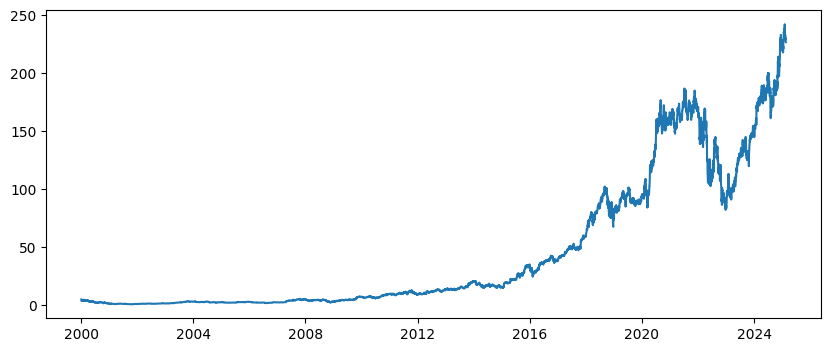

In [68]:
df['date'] = pd.to_datetime(df['date'])

# Create the plot
plt.figure(figsize=(10, 4))  # Set figure size
plt.plot(df['date'], df['adj_close'])

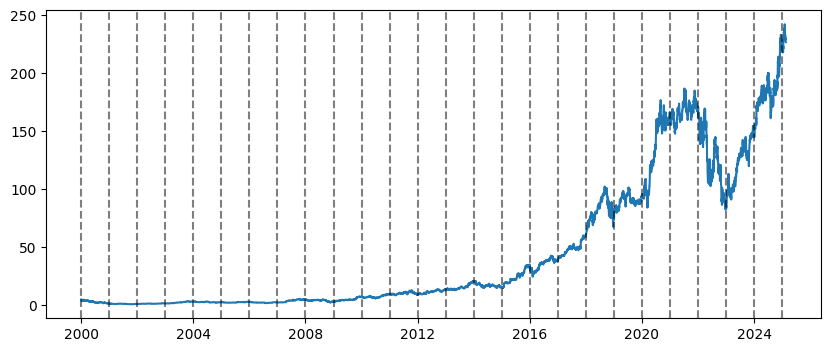

In [69]:
start_year = df['date'].dt.year.min()
end_year = df['date'].dt.year.max()

plt.figure(figsize=(10, 4))  # Set figure size
plt.plot(df['date'], df['adj_close'])

for year in range(start_year, end_year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

In [70]:
df.set_index('date', inplace=True)
stl = STL(df['adj_close'], period=252)  # Change period based on your data's seasonality
result = stl.fit()

In [71]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

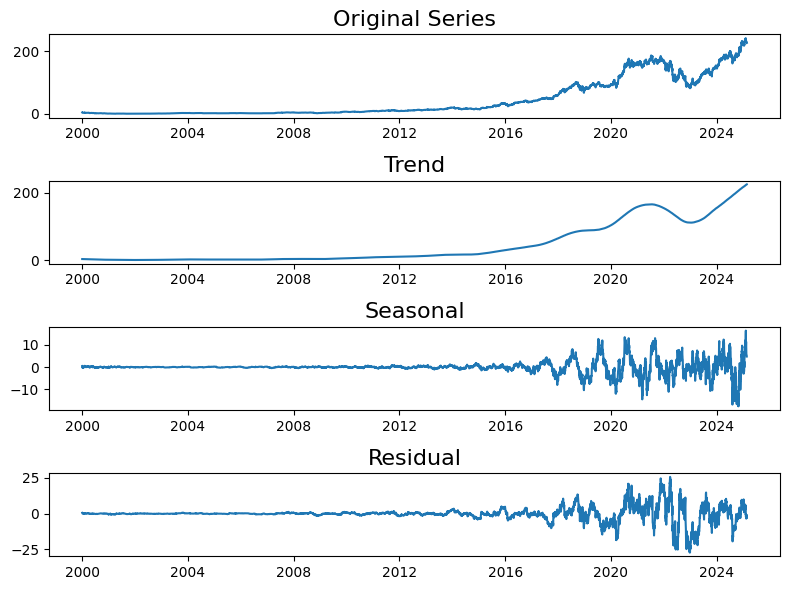

In [72]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

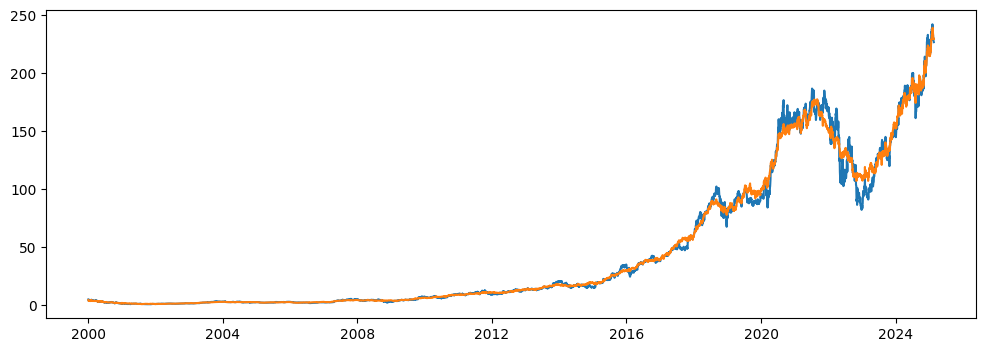

In [73]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df)
plt.plot(estimated)

In [74]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(np.float64(10959.0), np.float64(20138.0))

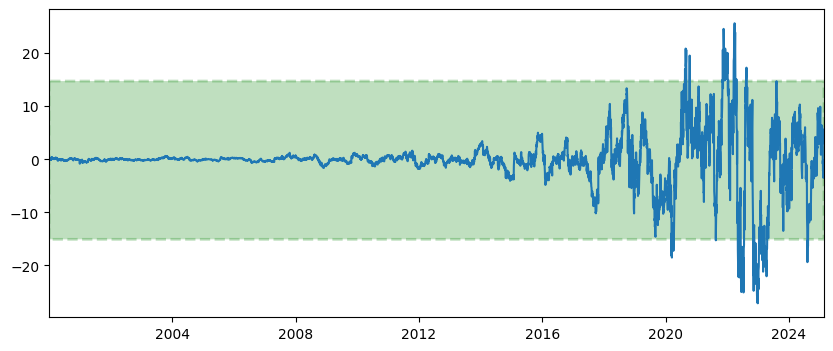

In [75]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between(resid.index, lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(resid.index.min(), resid.index.max())

In [76]:
anomalies = df[(resid<lower) | (resid>upper)]

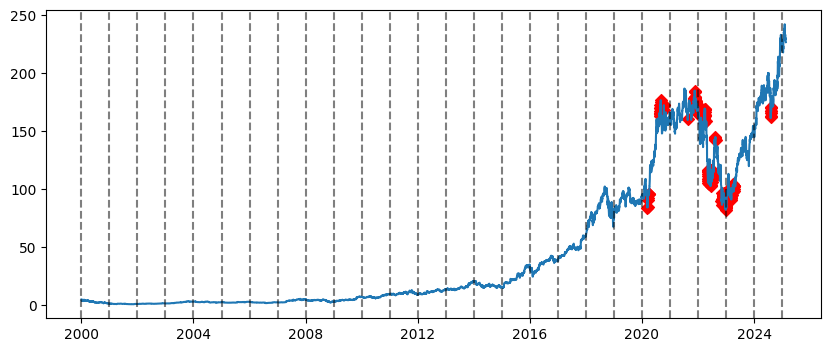

In [77]:
plt.figure(figsize=(10,4))
plt.plot(df)
for year in range(start_year, end_year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies.index, anomalies.adj_close, color='r', marker='D')

In [78]:
anomalies

,adj_close
date,
2020-03-12,83.830498
2020-03-16,84.457497
2020-03-17,90.391998
2020-03-20,92.304497
2020-04-01,95.385002
...,...
2024-08-08,165.800003
2024-08-09,166.940002
2024-08-12,166.800003


In [80]:
anomaly_months = anomalies.index.strftime('%Y-%m').unique().tolist()
print(anomaly_months)

['2020-03', '2020-04', '2020-08', '2020-09', '2020-10', '2021-08', '2021-11', '2021-12', '2022-01', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2024-08']


In [81]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("GOOGLE_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your GOOGLE_API_KEY ········
Please provide your TAVILY_API_KEY ········


In [ ]:
!pip install langchain langchain-google-genai langchain-community tavily-python

In [83]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults
import requests
from datetime import datetime

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [84]:
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END

class AgentState(BaseModel):
    month: str
    news: list = Field(default_factory=list)  # Default empty list
    report: str = ""  # Default empty string

In [85]:
def fetch_data(state):
    search = TavilySearchResults(max_results=5) 
    month_date = datetime.strptime(state.month, "%Y-%m")
    formatted_month = month_date.strftime("%B %Y")
    query = f"Amazon stock data news {formatted_month}"
    news = search.run(query)
    return AgentState(month=state.month, news=news)

def generate_report(state):
    prompt = f"""
    Given the following news articles:
    {state.news[:]}

    Explain why there was an anomaly in Amazon stock data in {state.month}.
    Give ranked list of explanations and append url related to news from {state.news}.
    """
    response = llm.predict(prompt)
    return AgentState(month=state.month, news=state.news, report=response)

In [86]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("fetch_data", fetch_data)
workflow.set_entry_point("fetch_data")

workflow.add_node("generate_report", generate_report)
workflow.add_edge("fetch_data", "generate_report")

workflow.add_edge("generate_report", END)

app = workflow.compile()

for month in anomaly_months:
    output = app.invoke(AgentState(month=month))
    #print(f"Output for {month}:\n{output}\n")
    print(f"{'='*150}\n")
    if isinstance(output, dict):
        print(f"Anomaly in {month}:\n{output.get('report', 'No report found')}\n\n{'='*150}")
    else:
        print(f"Anomaly in {month}:\n{output.report}\n{'='*150}")

C:\Users\Sandaru Fernando\AppData\Local\Temp\ipykernel_11272\3875333163.py:17: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.predict(prompt)



Anomaly in 2020-03:
The anomaly in Amazon stock data in March 2020 was a significant drop in price. Here's a ranked list of explanations based on the provided articles:

1.  **Market-wide Downturn (Likely due to COVID-19 Pandemic):** The Forbes article mentions that AMZN stock fell 22.7% from a high of $108.51 on February 19, 2020, to $83.83 on March 12, 2020. This coincided with a broader market decline, as the S&P 500 experienced a peak-to-trough decline of 33.9% during the same period. This suggests a systemic risk factor affecting the entire market, likely triggered by the onset of the COVID-19 pandemic and associated economic fears.

    *   **URL:** [https://www.forbes.com/sites/greatspeculations/2025/03/04/should-you-buy-amazon-stock-despite-its-high-valuation/](https://www.forbes.com/sites/greatspeculations/2025/03/04/should-you-buy-amazon-stock-despite-its-high-valuation/)

2.  **Specific Amazon Stock Volatility:** The drop in Amazon's stock price was substantial. The MarketW